In [276]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt


In [277]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr)

## Data preprocessing for helloworld.wav (testing, optional to run)

In [ ]:
sample0, sr0 = librosa.load("wav/test.wav")


In [279]:
sr0

22050

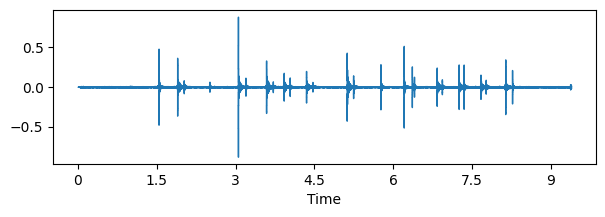

In [280]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(sample0, sr=sr0)

In [281]:
# Unified parameters (run this once)
n_fft = 1024
hop_length = 256
before = 2400
after = 5000

# threshold percentile used inside isolator when threshold=None
threshold_percentile = 96

# 최소 키 누르기 간격 (초 단위) - 동시 타이핑 고려
min_keystroke_gap = 0.03  # 50ms (손가락 2개 겹침 허용), 필요시 0.03~0.1로 조정

# band-limited energy for keystroke detection
band_fmin = 1000
band_fmax = 13000


In [282]:
#Calculating the STFT of the Sample
fft = librosa.stft(sample0, n_fft = n_fft , hop_length = hop_length)

In [283]:
#Calculating the Energy of the Signal using FFT
#energy = np.abs(np.sum(fft, axis=0)).astype(float)
energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)


In [284]:
len(energy), len(sample0), len(fft)

(809, 206976, 513)

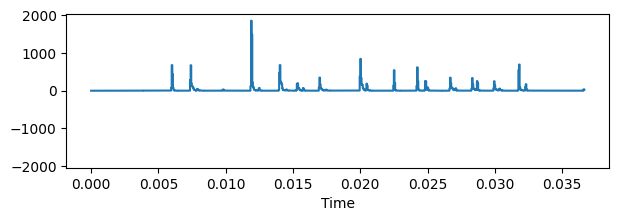

In [285]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(energy)

In [286]:
# Band-limited energy (focus on keystroke band)
fft = librosa.stft(sample0, n_fft=n_fft, hop_length=hop_length)
frequencies = librosa.fft_frequencies(sr=sr0, n_fft=n_fft)
band_mask = (frequencies >= band_fmin) & (frequencies <= band_fmax)
energy = np.sum(np.abs(fft[band_mask])**2, axis=0)

#threshold = 0.9
threshold = np.percentile(energy, threshold_percentile)   # 95~99 사이로 조절
#med = np.median(energy)
#mad = np.median(np.abs(energy - med))
#threshold = med + 6 * mad   # 6~10 범위로 조절

#Converting into Binary
threshed = energy > threshold


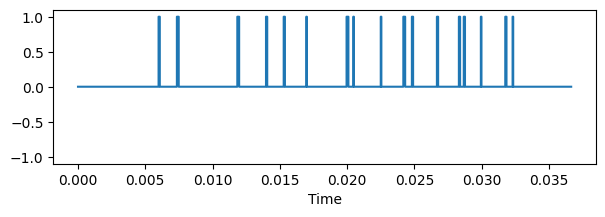

In [287]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(threshed.astype(float))

In [288]:
peaks = np.where(threshed == True)[0]
print(peaks)


[132 133 162 163 164 261 262 263 308 309 337 338 374 440 441 442 451 496
 533 534 535 547 548 588 589 624 625 632 633 660 700 701 712]


In [289]:
peak_count = len(peaks)
print(peak_count)

33


In [290]:
prev_end = sr0*0.1*(-1)

In [291]:
strokes = []
stroke_times = []  # IKI 계산을 위해 타이밍 기록

/var/folders/mz/2wl7n1990lv2x93xqyw579x80000gn/T/ipykernel_96140/3192214822.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 2))


<Figure size 700x200 with 0 Axes>

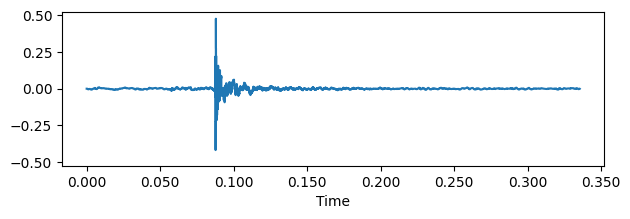

<Figure size 700x200 with 0 Axes>

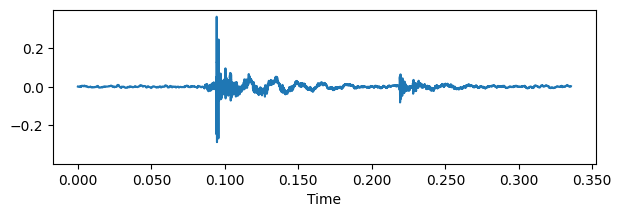

<Figure size 700x200 with 0 Axes>

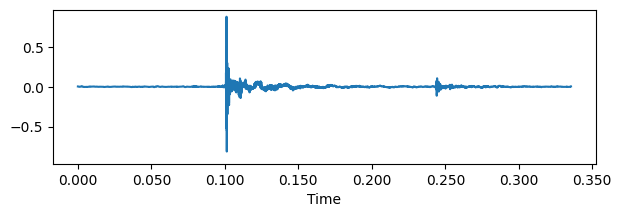

<Figure size 700x200 with 0 Axes>

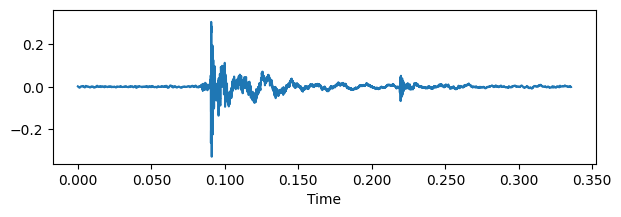

<Figure size 700x200 with 0 Axes>

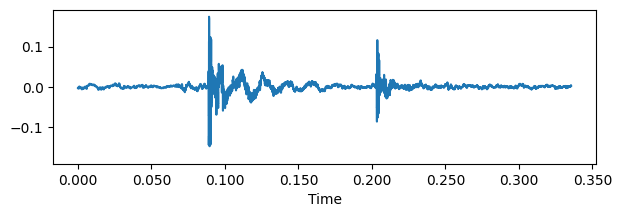

<Figure size 700x200 with 0 Axes>

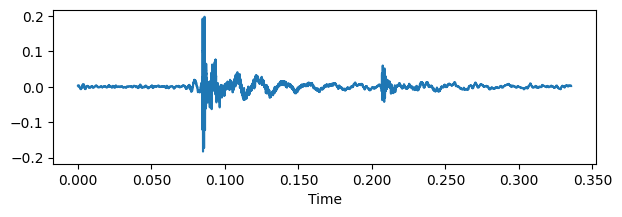

<Figure size 700x200 with 0 Axes>

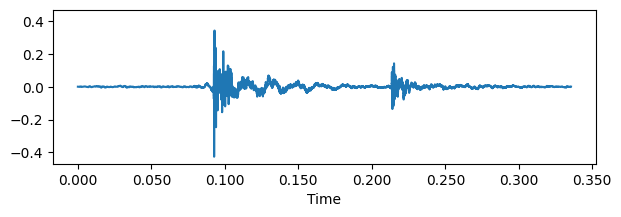

<Figure size 700x200 with 0 Axes>

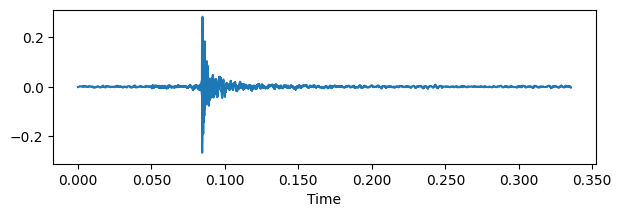

<Figure size 700x200 with 0 Axes>

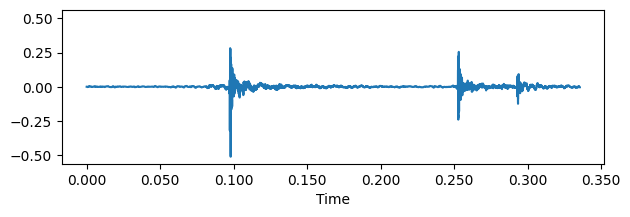

<Figure size 700x200 with 0 Axes>

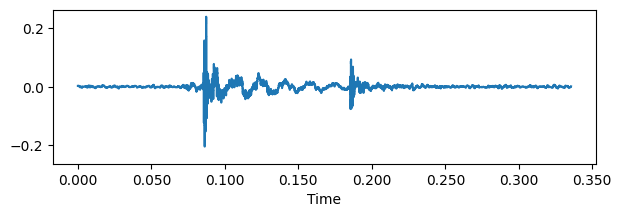

<Figure size 700x200 with 0 Axes>

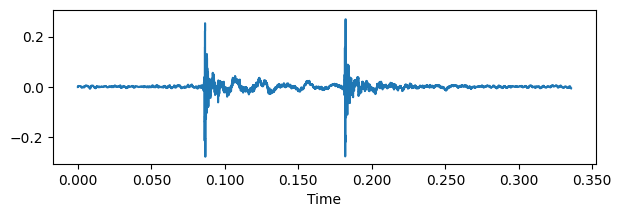

<Figure size 700x200 with 0 Axes>

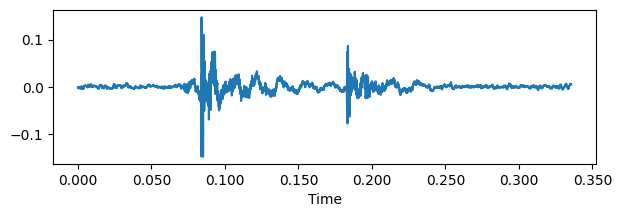

<Figure size 700x200 with 0 Axes>

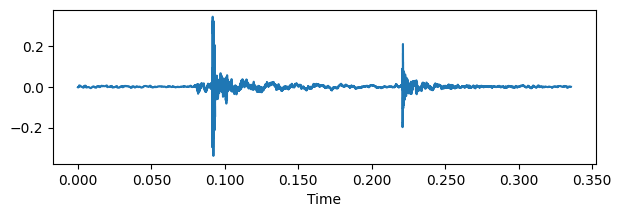

In [292]:
for i in range(peak_count):
  this_peak = peaks[i]
  timestamp = (this_peak*hop_length) + n_fft//2
  if timestamp > prev_end + (min_keystroke_gap * sr0):
    keystroke = sample0[timestamp-before:timestamp+after]
    strokes.append(torch.tensor(keystroke)[None, :])
    stroke_times.append(timestamp / sr0)  # 초 단위로 타이밍 기록
    plt.figure(figsize=(7, 2))
    disp_waveform(keystroke, sr=sr0)
    prev_end = timestamp+after

In [293]:
strokes

[tensor([[ 2.1417e-04,  4.5750e-05, -1.3104e-04,  ..., -1.3752e-03,
          -1.0906e-03, -7.8405e-04]]),
 tensor([[0.0009, 0.0007, 0.0005,  ..., 0.0018, 0.0020, 0.0020]]),
 tensor([[0.0032, 0.0031, 0.0029,  ..., 0.0060, 0.0060, 0.0058]]),
 tensor([[ 0.0020,  0.0016,  0.0013,  ..., -0.0002, -0.0006, -0.0010]]),
 tensor([[-0.0029, -0.0031, -0.0034,  ...,  0.0032,  0.0027,  0.0025]]),
 tensor([[0.0020, 0.0023, 0.0028,  ..., 0.0026, 0.0024, 0.0019]]),
 tensor([[ 1.9821e-04,  1.6782e-04,  2.2035e-04,  ..., -5.3457e-04,
           1.2220e-06,  2.9426e-04]]),
 tensor([[-0.0014, -0.0015, -0.0015,  ..., -0.0040, -0.0040, -0.0038]]),
 tensor([[-0.0002, -0.0004, -0.0006,  ..., -0.0024, -0.0032, -0.0037]]),
 tensor([[ 0.0026,  0.0031,  0.0035,  ..., -0.0001,  0.0005,  0.0013]]),
 tensor([[-0.0014, -0.0008, -0.0002,  ..., -0.0065, -0.0066, -0.0066]]),
 tensor([[-0.0026, -0.0023, -0.0021,  ...,  0.0049,  0.0049,  0.0049]]),
 tensor([[-0.0026, -0.0030, -0.0034,  ..., -0.0012, -0.0010, -0.0008]])]

In [294]:
print("peaks:", len(peaks))
print("strokes:", len(strokes))


peaks: 33
strokes: 13


Stroke count: 13
IKI (초): [0.34829932 1.14938776 0.54566893 0.33668934 0.42956916 0.7662585
 0.65015873 0.42956916 0.63854875 0.41795918 0.41795918 0.46439909]
IKI (ms): [ 348.29931973 1149.3877551   545.66893424  336.6893424   429.569161
  766.2585034   650.15873016  429.569161    638.54875283  417.95918367
  417.95918367  464.39909297]
stroke_times: [np.float64(1.555736961451247), np.float64(1.9040362811791383), np.float64(3.053424036281179), np.float64(3.599092970521542), np.float64(3.93578231292517), np.float64(4.365351473922902), np.float64(5.131609977324263), np.float64(5.7817687074829935), np.float64(6.211337868480726), np.float64(6.849886621315193), np.float64(7.267845804988662), np.float64(7.685804988662132), np.float64(8.150204081632653)]
0 1.555736961451247 1.9040362811791383 0.3482993197278912


<Figure size 800x200 with 0 Axes>

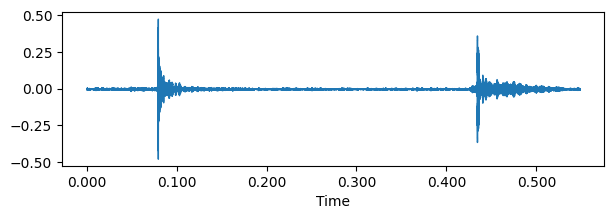

3 3.599092970521542 3.93578231292517 0.3366893424036279


<Figure size 800x200 with 0 Axes>

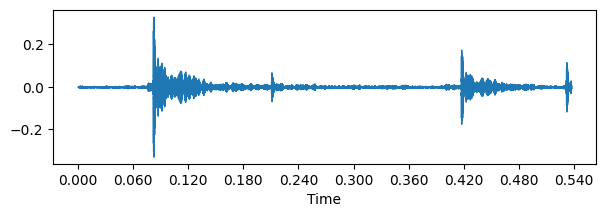

In [295]:
iki = np.diff(stroke_times)
print(f"Stroke count: {len(stroke_times)}")
print(f"IKI (초): {iki}")
print(f"IKI (ms): {iki * 1000}")


print("stroke_times:", stroke_times)

if len(stroke_times) < 2:
    print("=> stroke_times가 2개 미만입니다. isolator/peaks 확인 필요.")
else:
    iki = np.diff(np.array(stroke_times))
    
    short_idx = np.where(iki < 0.4)[0]
    

   
    for i in short_idx:
        print(i, stroke_times[i], stroke_times[i+1], iki[i])
        start = int(max(0, (stroke_times[i]-0.1)*sr0))
        end = int(min(len(sample0), (stroke_times[i+1]+0.1)*sr0))
        plt.figure(figsize=(8,2))
        disp_waveform(sample0[start:end], sr=sr0)
        plt.show()

In [296]:
spect = librosa.feature.melspectrogram(y=np.asarray(strokes[0]), n_mels=64, hop_length=225)


In [297]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold=None, show=False,
             band_fmin=None, band_fmax=None):
    strokes = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

    # band-limited energy (optional)
    if band_fmin is not None or band_fmax is not None:
        freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
        if band_fmin is None:
            band_fmin = 0
        if band_fmax is None:
            band_fmax = freqs[-1]
        band_mask = (freqs >= band_fmin) & (freqs <= band_fmax)
        energy = np.sum(np.abs(fft[band_mask])**2, axis=0)
    else:
        energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)

    # threshold auto from same signal unless provided
    if threshold is None:
        threshold = np.percentile(energy, threshold_percentile)
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            strokes.append(keystroke)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    print("peaks:", len(peaks))
    print("strokes:", len(strokes))
    
    return strokes


In [298]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc, sr=None)
        # samples, sr = librosa.load(loc,sr=None,duration=1.0,mono=True)

        strokes = []
        thr = np.percentile(energy, 97) 
        step = 0.005
        strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, thr, False )
        # while not len(strokes) == 25:
        #   strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, prom, False )
        #   if len(strokes) < 25:
        #     prom -= step
        #   if len(strokes) > 25:
        #     prom += step
        #   if prom < 0:
        #     print("--not possible for : ", File)
        #     break
        #   step = step * 0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

## Generating MelSpectrograms

In [299]:
# Create mel-spectrogram images for test dataset keystrokes (sample settings)
from pathlib import Path
import matplotlib.pyplot as plt
import librosa.display

test_dir = Path('wav')
out_root = Path('out/test')
out_root.mkdir(parents=True, exist_ok=True)

# sample-style parameters
before = 2400
after = 5000

for wav_path in sorted(test_dir.glob('*.wav')):
    key = wav_path.stem
    samples, sr = librosa.load(wav_path.as_posix())

    print("file:", wav_path.name)
    print("sr:", sr, "len:", len(samples))
    print("n_fft:", n_fft, "hop:", hop_length, "before:", before, "after:", after)

    # isolate keystrokes with auto-threshold on the same signal
    strokes = isolator(samples, sr, n_fft, hop_length, before, after, threshold=None, show=False)
    key_out = out_root / key
    key_out.mkdir(parents=True, exist_ok=True)
    for i, stroke in enumerate(strokes):
        mel = librosa.feature.melspectrogram(
            y=np.asarray(stroke).squeeze(),
            sr=sr,
            n_mels=64,
            n_fft=1024,
            hop_length=225,
        )
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(
            librosa.power_to_db(mel, ref=np.max),
            x_axis='time',
            y_axis='mel',
            sr=sr,
            hop_length=225,
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram ({key}) - keystroke {i}')
        plt.tight_layout()
        plt.savefig(key_out / f'keystroke_{i:04d}.png', dpi=150)
        plt.close()


file: Hello World 2.wav
sr: 22050 len: 340570
n_fft: 1024 hop: 256 before: 2400 after: 5000
peaks: 54
strokes: 14


file: Hello World.wav
sr: 22050 len: 206976
n_fft: 1024 hop: 256 before: 2400 after: 5000
peaks: 33
strokes: 13
file: test.wav
sr: 22050 len: 335396
n_fft: 1024 hop: 256 before: 2400 after: 5000
peaks: 53
strokes: 24


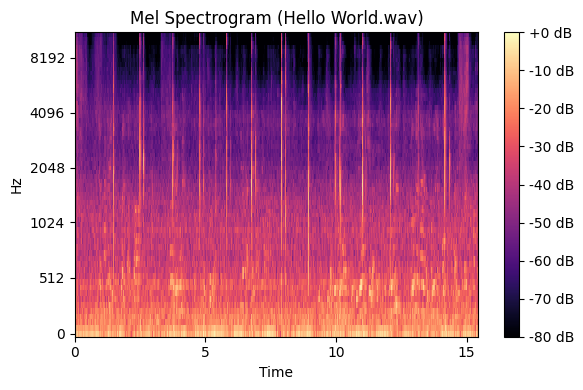

In [300]:
# Mel-spectrogram image for Hello World 2.wav
import matplotlib.pyplot as plt
import librosa.display
sample_hw2, sr_hw2 = librosa.load("wav/Hello World 2.wav")
mel_hw2 = librosa.feature.melspectrogram(
    y=sample_hw2, sr=sr_hw2, n_mels=64, n_fft=1024, hop_length=225
)
plt.figure(figsize=(6, 4))
librosa.display.specshow(librosa.power_to_db(mel_hw2, ref=np.max), x_axis='time', y_axis='mel', sr=sr_hw2, hop_length=225)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Hello World.wav)')
plt.tight_layout()
plt.show()
